# A2: Written Assessment (Individual) - Classification Modeling Case Study

### Elizabeth Parker Schooley - MSFBA5

### March 15, 2020

> This report will cover the process of exploratory data analysis of the Apprentice Chef Dataset, as well as chosen feature engineering techniques, and ultimately modeling frameworks chosen. This is a classification predictive model will utilize CROSS_SELL_SUCCESS as the target variables and all remaining variables will initially start-off as potential explanatory variables for the model.

> It should be noted that a feature was added to the initial dataset using external research. After confirming all values were duplicates in the name and first_name columns, a column was added indicating if the person was a male or female (1=male, and 0=female). The source of this additional variable can be found following this link: <https://www.kaggle.com/mylesoneill/game-of-thrones#character-predictions.csv> and navigating to the character-predictions.csv. 

### Section I

#### EDA Processes and Feature Engineering
> 1. Importing all necessary packages and user defined functions created by Professor Chase Kusterer
> 2. Checking the head, type of each variable, and for null values: 47 null values were detected in the Family_Name column
> 3. Created a feature to classify by Apprentice Chef's email domain categories by splitting the emails from their domain and classifying as: personal, professional, junk.
> 4. Created a feature called Total_Logins, which is the sum of PC_logins and Mobile_logins
> 5. Dropped the following non-numerical columns: FAMILY_NAME, NAME, FIRST_NAME, EMAIL, personal_email_domain, domain_group and junk (to avoid dummy variable trap).
> 6. Checked for missing values again and confirmed none are present
> 7. Took counts of categorical variable groups to confirm n > 75 for each category 
> 8. Proceed with EDA by generating histograms and boxplots for each variable to observe outliers
> 9. Created outlier thresholds with necessary variables as either a low or high threshold 
> 10. Created feature columns for each outlier threshold 
> 11. Dataframes with variables and list of labels were created for both the target variable and explanatory variables

#### Package and User-Defined Functions Import

In [17]:
# importing libraries
import random            as rand                     # random number gen
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler

# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend                                  

# Hyperparameters
from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer



In [18]:
#importing all user defined functions

########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=222,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 802
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    

########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')
        


#### Loading in raw data frame and feature engineering emails

In [19]:
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#loading in raw data file
file = 'Apprentice_Chef_Dataset A2.xlsx'
chef = pd.read_excel(file)

#checking label names
#chef.head(n = 5)

#checking types of variables
#type(chef)

#FEATURE ENGINEERING
# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef.iterrows():
    
    # splitting email domain at '@'
    split_email = chef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

# STEP 2: concatenating with original DataFrame

# renaming column to concatenate
email_df.columns = ['0' , 'personal_email_domain']


# concatenating personal_email_domain with chef DataFrame
chef = pd.concat([chef, email_df['personal_email_domain']],
                     axis = 1)


# printing value counts of personal_email_domain
chef.loc[: ,'personal_email_domain'].value_counts()

# email domain types
personal_email_domains = ['@gmail.com', '@yahoo.com', '@protonmail.com']
professional_email_domains  = ['@mmm.com', '@amex.com', '@apple.com', '@boeing.com', 
                               '@caterpillar.com', '@chevron.com', '@cisco.com', 
                               '@cocacola.com', '@disney.com', '@dupont.com', 
                               '@exxon.com', '@ge.org', '@goldmansacs.com', '@homedepot.com', 
                               '@ibm.com', '@intel.com', '@jnj.com', '@jpmorgan.com',
                               '@mcdonalds.com', '@merck.com', '@microsoft.com', 
                               '@nike.com', '@pfizer.com', '@pg.com', '@travelers.com', 
                               '@unitedtech.com', '@unitedhealth.com', '@verizon.com', 
                               '@visa.com', '@walmart.com']
junk_email_domains = ['@me.com', '@aol.com', '@hotmail.com', '@live.com',
                     '@msn.com', '@passport.com']


# placeholder list
placeholder_lst = []


# looping to group observations by domain type
for domain in chef['personal_email_domain']:
    
    if '@' + domain in personal_email_domains:
        placeholder_lst.append('personal')
        

    elif '@' + domain in professional_email_domains:
        placeholder_lst.append('professional')
        
    elif '@' + domain in junk_email_domains:
        placeholder_lst.append('junk')


    else:
            print('Unknown')


# concatenating with original DataFrame
chef['domain_group'] = pd.Series(placeholder_lst)


# checking results
chef['domain_group'].value_counts()

# one hot encoding categorical variables
one_hot_email       = pd.get_dummies(chef['domain_group'])

# joining codings together
chef = chef.join([one_hot_email])

#checking for missing values
#chef.isnull().any()

#chef.columns 



#### Dropping Non-Numerical and Non-encoded categorical variables and Creating Outlier Threshold Features

In [20]:
#dropping FAMILY_NAME, NAME, FIRST_NAME, EMAIL, personal_email_domain
#domain_group and junk (to avoid dummy variable trap)
#feature engineered new categorical column with 'male' which tells
#whether each first_name is a male or female, 
#email categories, and total_logins 


#loading saved file
data = chef

#creating dataframe with desired variables
df = pd.DataFrame(data = data, columns = ['CROSS_SELL_SUCCESS', 'REVENUE', 'male', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
       'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 
       'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 
       'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 
       'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 
       'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT', 'AVG_PREP_VID_TIME', 
       'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 
       'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 'personal', 'professional'])


#df.columns


#setting outlier flags after visual histogram EDA and box plot EDA 
#on all variables
REVENUE_hi = 3000
AVG_TIME_PER_SITE_VISIT_hi = 220
AVG_PREP_VID_TIME_hi = 200
CONTACTS_W_CUSTOMER_SERVICE_hi = 9
AVG_CLICKS_PER_VISIT_lo = 10
TOTAL_MEALS_ORDERED_hi  = 106
UNIQUE_MEALS_PURCH_hi = 9
CANCELLATIONS_BEFORE_NOON_hi = 4
WEEKLY_PLAN_hi = 16
EARLY_DELIVERIES_hi = 4
LATE_DELIVERIES_hi = 5
LARGEST_ORDER_SIZE_lo = 3
LARGEST_ORDER_SIZE_hi = 6
TOTAL_PHOTOS_VIEWED_hi = 220
MEDIAN_MEAL_RATING_hi = 4

##############################################################################
## Feature Engineering (outlier thresholds)                                 ##
##############################################################################

# developing features (columns) for outliers

# Revenue
df['out_REVENUE'] = 0
condition_hi = df.loc[0:,'out_REVENUE'][df['REVENUE'] > REVENUE_hi]

df['out_REVENUE'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)


# Average Time Per Site Visit
df['out_AVG_TIME_PER_SITE_VISIT'] = 0
condition_hi = df.loc[0:,'out_AVG_TIME_PER_SITE_VISIT'][df['AVG_TIME_PER_SITE_VISIT'] > AVG_TIME_PER_SITE_VISIT_hi]

df['out_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)


# Largest Order Size
df['out_LARGEST_ORDER_SIZE'] = 0
condition_hi = df.loc[0:,'out_LARGEST_ORDER_SIZE'][df['LARGEST_ORDER_SIZE'] > LARGEST_ORDER_SIZE_hi]
condition_lo = df.loc[0:,'out_LARGEST_ORDER_SIZE'][df['LARGEST_ORDER_SIZE'] < LARGEST_ORDER_SIZE_lo]

df['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

df['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)


# Average Clicks Per Visit
df['out_AVG_CLICKS_PER_VISIT'] = 0
condition_lo = df.loc[0:,'out_AVG_CLICKS_PER_VISIT'][df['AVG_CLICKS_PER_VISIT'] < AVG_CLICKS_PER_VISIT_lo]

df['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)


# Average Prep Video Time
df['out_AVG_PREP_VID_TIME'] = 0
condition_hi = df.loc[0:,'out_AVG_PREP_VID_TIME'][df['AVG_PREP_VID_TIME'] > AVG_PREP_VID_TIME_hi]

df['out_AVG_PREP_VID_TIME'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)


# Contacts wit Customer Service
df['out_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition_hi = df.loc[0:,'out_CONTACTS_W_CUSTOMER_SERVICE'][df['CONTACTS_W_CUSTOMER_SERVICE'] > CONTACTS_W_CUSTOMER_SERVICE_hi]

df['out_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)


# Total Meals Ordered
df['out_TOTAL_MEALS_ORDERED'] = 0
condition_hi = df.loc[0:,'out_TOTAL_MEALS_ORDERED'][df['TOTAL_MEALS_ORDERED'] > TOTAL_MEALS_ORDERED_hi]

df['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)


# Unique Meals Purchased
df['out_UNIQUE_MEALS_PURCH'] = 0
condition_hi = df.loc[0:,'out_UNIQUE_MEALS_PURCH'][df['UNIQUE_MEALS_PURCH'] > UNIQUE_MEALS_PURCH_hi]

df['out_UNIQUE_MEALS_PURCH'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Cancellations Before Noon
df['out_CANCELLATIONS_BEFORE_NOON'] = 0
condition_hi = df.loc[0:,'out_CANCELLATIONS_BEFORE_NOON'][df['CANCELLATIONS_BEFORE_NOON'] > CANCELLATIONS_BEFORE_NOON_hi]

df['out_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Weekly Plan
df['out_WEEKLY_PLAN'] = 0
condition_hi = df.loc[0:,'out_WEEKLY_PLAN'][df['WEEKLY_PLAN'] > WEEKLY_PLAN_hi]

df['out_WEEKLY_PLAN'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Early Deliveries
df['out_EARLY_DELIVERIES'] = 0
condition_hi = df.loc[0:,'out_EARLY_DELIVERIES'][df['EARLY_DELIVERIES'] > EARLY_DELIVERIES_hi]

df['out_EARLY_DELIVERIES'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Late Deliveries
df['out_LATE_DELIVERIES'] = 0
condition_hi = df.loc[0:,'out_LATE_DELIVERIES'][df['LATE_DELIVERIES'] > LATE_DELIVERIES_hi]

df['out_LATE_DELIVERIES'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Total Photos Viewed
df['out_TOTAL_PHOTOS_VIEWED'] = 0
condition_hi = df.loc[0:,'out_TOTAL_PHOTOS_VIEWED'][df['TOTAL_PHOTOS_VIEWED'] > TOTAL_PHOTOS_VIEWED_hi]

df['out_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)


# Median Meal Rating
df['out_MEDIAN_MEAL_RATING'] = 0
condition_hi = df.loc[0:,'out_MEDIAN_MEAL_RATING'][df['MEDIAN_MEAL_RATING'] > MEDIAN_MEAL_RATING_hi]

df['out_MEDIAN_MEAL_RATING'].replace(to_replace = condition_hi,
                                 value      = 1,
                                 inplace    = True)

# New feature total logins (PC logins + mobile logins)
df['total_logins'] = df['PC_LOGINS']+df['MOBILE_LOGINS']


### Section II

#### Modeling Techniques

> 1. Examined Pearson Correlation Coefficients for each explanatory variable with the response variable:

####   The Top 7 Correlated Variables with CROSS_SELL_SUCCESS:
                FOLLOWED_RECOMMENDATIONS_PCT       0.46
                professional                       0.19
                CANCELLATIONS_BEFORE_NOON          0.16
                MOBILE_NUMBER                      0.10
                TASTES_AND_PREFERENCES             0.08
                REFRIGERATED_LOCKER                0.07
                out_CANCELLATIONS_BEFORE_NOON      0.06
> 2. Created a full logit model with smf.logit including all explanatory variables
> 3. Defined the list below (df_sig) containing independent variables with P-values < 0.05, with the exception of REFRIGERATED LOCKER, which initially had a P-value of 0.091, but upon developing multiple models with only the significant variables, REFRIGERATED_LOCKER continued to be significant 
> 4. A second model was developed with only significant variables from the full logit model with a Current Function Value = 0.436
> 5. Implemented test, train, split with a test size of 0.25 and random state of 222, and the stratify argument set to 'True' upon reviewing samples with CROSS_SELL_SUCCESS = 1 and CROSS_SELL_SUCCESS = 0 
> 6. Upon reviewing the descriptive statistics of each variable and quantile plot, it was decided to implement StandardScaler to scale all features in an effort to consider all features uniformly 
> 7. A Logistic Regression classifier was instantiated and run on the scaled significant explanatory variables 
> 8. Model was fit on the X and Y training data and predicted results X test data to produce a Training Accuracy = 0.763 and Testing Accuracy = 0.762
> 9. Confusion Matrix of the Classifier was created and area under the ROC curve was calculated and = 0.706
> 10. The optimal number of neighbors was found using the user-defined function provided above in order to instantiate the KNN classification model
> 11. The KNN classification model was fitted on the previously scaled explanatory variables the model performance is summarized below:

                > Training ACCURACY: 0.806
                  Testing  ACCURACY: 0.7228
                  AUC Score        : 0.7063
> 12. A Decision Tree Classifier was instantiated on all non-scaled explanatory variables. After testing, training, splitting, fitting, and predicting the Full Tree Model, the results were produced below:

                 > Training ACCURACY: 0.862
                   Testing  ACCURACY: 0.77
                   AUC Score        : 0.7512
                   
> 13. To prevent overfitting, a second pruned Decision Tree Classifier was instantiated and fit on the following set of variables identified as significant features from the original logit model: 

      > 'MOBILE_NUMBER', 
        'CANCELLATIONS_BEFORE_NOON',
        'TASTES_AND_PREFERENCES',
        'FOLLOWED_RECOMMENDATIONS_PCT',
        'personal',
        'professional',
        'out_CANCELLATIONS_BEFORE_NOON',
        'REFRIGERATED_LOCKER'
> 14. These features were scaled and the pruned Decision Tree Classifier produced the following results: 

                    > Training ACCURACY: 0.8033
                      Testing  ACCURACY: 0.7926
                      AUC Score        : 0.7763
                      
> 15. A bar chart of the Pruned Decision Tree's Important Features was created identifying the following features as most important:

           > 1. FOLLOWED_RECOMMENDATIONS_PCT (approximately 0.8)
             2. professional
             3. personal
             4. CANCELLATIONS_BEFORE_NOON 
             5. MOBILE_NUMBER
        * all features following feature 1 were below 0.2
> 16. After completing testing, training, predicting and fitting using scaled, unscaled, all explanatory variables, and only initially identified explanatory variables and instantiating KNN Classifier Model, Logit Model, Logistic Regression Classifier Model, Decision Tree Unpruned and Pruned Classifier Models, and Random Forest Classifier Model, the bet performing model was created and can be seen below:




### Section III

#### Best Performing Modeling Technique and Hyperparameter Tuning

> The model performing the highest in it's AUC score utilized the significant variables identified throughout my iterative modeling technique processes. The significant explanatory variables in the final model were: 

    > FINAL MODEL EXPLANATORY VARIABLES:
        'MOBILE_NUMBER', 
        'CANCELLATIONS_BEFORE_NOON',
        'TASTES_AND_PREFERENCES',
        'FOLLOWED_RECOMMENDATIONS_PCT',
        'personal',
        'professional',
        'out_CANCELLATIONS_BEFORE_NOON',
        'REFRIGERATED_LOCKER'
        
#### Final Model Process
> 1. Explanatory variables were scaled, trained, tested, and spit with a test size = 0.25 and random state = 222
> 2. Hyperparameter space was declared and a GridSearchCV object was created to automate the search for the optimal hyperparameters
> 3. The Tuned Parameters were found to be: 'criterion'= 'entropy', 'max_depth'= 5, 'min_samples_leaf'= 2, 'splitter'= 'best'
> 4. A Logistic Regression Model with tuned values was instantiated using lr_tuned_cv.best_estimator_
> 5. This model yielded the following results:

                            > Training ACCURACY: 0.8177
                              Testing  ACCURACY: 0.8131
                              AUC Score        : 0.7829
> 6. The Tuned Tree important features were plotted for this model, identifying most important features as: 

         > 1. FOLLOWED_RECOMMENDATIONS_PCT (approximately 0.8)
           2. professional
           3. personal
           4. CANCELLATIONS_BEFORE_NOON 
           5. MOBILE_NUMBER
           6. REFRIGERATED_LOCKER
           7. TASTES AND PREFERENCES
        * all features following feature 1 were below 0.2
        * features 6 and 7 were approximately equal in importance 

In [21]:
#defining explanatory variables and target
xVar = list(df.loc[:,'REVENUE':'professional'])
df2 = df[xVar]
yVar = df.iloc[:,0]

#defining significant variables after full logistic regression run
df_sig = df[['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
                                        'TASTES_AND_PREFERENCES',
                                        'FOLLOWED_RECOMMENDATIONS_PCT',
                                        'personal',
                                        'professional',
                                        'out_CANCELLATIONS_BEFORE_NOON',
                                        'REFRIGERATED_LOCKER']]

# train/test split with the logit_sig variables
df_data   =  df_sig
df_target =  yVar

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)

In [22]:
# declaring a hyperparameter space
#criterion_space = ['gini', 'entropy']
#splitter_space = ['best', 'random']
#depth_space = pd.np.arange(1, 25)
#leaf_space  = pd.np.arange(1, 100)


# creating a hyperparameter grid
#param_grid = {'criterion'        : criterion_space,
#              'splitter'         : splitter_space,
#              'max_depth'        : depth_space,
#              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
#tuned_tree = DecisionTreeClassifier(random_state = 222)


# GridSearchCV object
#tuned_tree_cv = GridSearchCV(estimator  = tuned_tree,
#                             param_grid = param_grid,
#                             cv         = 3,
#                             scoring    = make_scorer(roc_auc_score,
#                                                      needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#tuned_tree_cv.fit(df_data, df_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", tuned_tree_cv.best_params_)
#print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

In [23]:
# building a model based on hyperparameter tuning results
# INSTANTIATING a Decision Tree Classifier model with tuned values
tree_tuned  = DecisionTreeClassifier(criterion = 'entropy',
                                             max_depth = 5,
                                              min_samples_leaf = 2,
                                             splitter = 'best',
                                              random_state = 222)
#FITTING the training data
tree_tuned_fit  = tree_tuned.fit(X_train, y_train)

# PREDICTING on new data
tree_pred = tree_tuned_fit.predict(X_test)
    
# SCORING the results
print('Training ACCURACY:', tree_tuned.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                              y_score = tree_pred).round(4))
    


Training ACCURACY: 0.8191
Testing  ACCURACY: 0.7864
AUC Score        : 0.7683


In [24]:
# displaying the tree
#display_tree(tree = tree_tuned,
             #feature_df = df_data,
             #height = 2000,
             #width  = 2000)



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:198: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


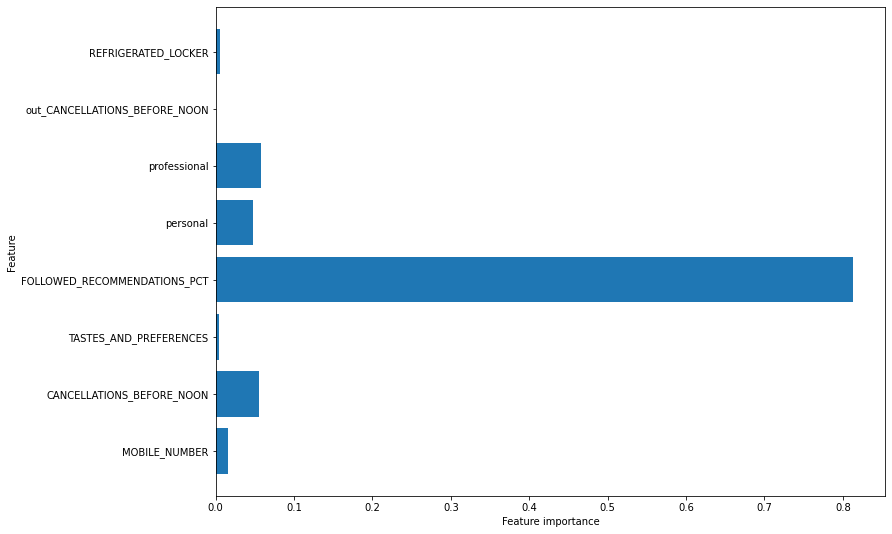

In [25]:
# plotting feature importance
plot_feature_importances(tree_tuned_fit,
                         train = X_train,
                         export = False)